<a href="https://colab.research.google.com/github/LuizVicenteJr/insiders_clustering/blob/main/insiders_clustering_cycle4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Planejamento da solução :

* Problema de negócio -> Selecionar os clientes mais valiosos para integrar um programa de fidelização

*Dataset -> Vendas de um e-commerce durante o período de um ano

#Perguntas da equipe de negócios :    
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
* Qual a expectativa de faturamente deste grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
*  Quais as condições para uma pessoa ser removida do Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de marketing pode realizar para aumentar o faturamento




# 0.0 IMPORTS

In [1]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap 
import regex as re

from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML



from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


## 0.1 HELPER FUNCTIONS

In [3]:
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

## 0.2 LOAD DATASET

In [4]:
df_raw = pd.read_csv('/content/Ecommerce.csv',encoding='unicode_escape')

#drop extra column
df_raw= df_raw.drop(columns=['Unnamed: 8'],axis=1)

# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [6]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_new =['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 DATA DIMENSIONS

In [8]:
print('Number of rows : {}'.format(df1.shape[0]))
print('Number of rows : {}'.format(df1.shape[1]))

Number of rows : 541909
Number of rows : 8


## 1.3 DATA TYPES

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 CHECK NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 REPLACE NA

In [11]:
df_missing= df1.loc[df1['customer_id'].isna(),:]
df_not_missing= df1.loc[~df1['customer_id'].isna(),:]

In [12]:
#create reference
df_backup= pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id']= np.arange(19000,19000 + len(df_backup),1)

#merge
df1=pd.merge(df1,df_backup,on='invoice_no',how='left')


#coalesce
df1['customer_id']= df1['customer_id_x'].combine_first(df1['customer_id_y'])  

#drop extra columns
df1= df1.drop(columns=['customer_id_x','customer_id_y'],axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


## 1.6 CHANGE DTYPES

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )

## 1.7 DESCRIPTIVE STATISTICS

In [15]:
num_attributes= df1.select_dtypes(include=['int64','float64'])
cat_attributes= df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
#central tendency
ct1= pd.DataFrame(num_attributes.apply(np.mean)).T
ct2= pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion
d1= pd.DataFrame(num_attributes.apply(np.std)).T
d2= pd.DataFrame(num_attributes.apply(np.min)).T
d3= pd.DataFrame(num_attributes.apply(np.max)).T
d4= pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5= pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6= pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red'> 1.7.1.1 Investigating</font>
* "quantity" negativa(pode ser devolução)
* "preço unitário igual a zero(pode ser algum tipo de promoção)

### 1.7.2 Categorical Attributes

### invoice_no

In [17]:
df_letter_invoices= df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:]
df_letter_invoices.head()

print('Total number of invoices: {}'.format( len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity']< 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


### stock code

In [18]:
#check stock code only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x) ) ),'stock_code'].unique()

#Remove stock code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### description

In [19]:
#ação: delete description

### country

In [20]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [21]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [22]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id',ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0 DATA FILTER

In [23]:
df2 = df1.copy()

In [24]:
###====  Numerical Attributes====###
#unit_price
df2= df2.loc[df2['unit_price']>= 0.04,:]

###====Categorical Attributes====###
#stock code
df2= df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                  'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#description
df2= df2.drop(columns='description',axis=1)

#map
df2=df2[~df2['country'].isin(['European Community','Unspecified'])]

#quantity
df2_returns= df2.loc[df2['quantity']< 0, :]
df2_purchases= df2.loc[df2['quantity']> 0, :]

# 3.0 FEATURE ENGINEERING
* Invoice_no = compra = purchase
* Stock Code = código do produto
* Quantity = quantidade do item
* Basket Size = quantidade de produtos por compra


In [25]:
df3 = df2.copy()

## 3.1 Feature Creation

In [26]:
df_ref= df3.drop(['invoice_no','stock_code','quantity',
                  'invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [27]:
#gross revenue 
df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:,'quantity'] * df2_purchases.loc[:,'unit_price']


#monetary
df_monetary= df2_purchases.loc[:,['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref= pd.merge(df_ref,df_monetary,on='customer_id',how='left')

df_ref.isna().sum()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency

In [28]:
#recency
df_recency= df2_purchases.loc[:,['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days']= (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency= df_recency[['customer_id','recency_days']].copy()

df_ref= pd.merge(df_ref,df_recency,on='customer_id',how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 quantity of purchased

In [41]:
#frequency
df_freq= (df2_purchases.loc[:,['customer_id','invoice_no']].drop_duplicates()
                                                          .groupby('customer_id')
                                                          .count().reset_index()
                                                          .rename(columns={'invoice_no':'qtde_invoices'}))

df_ref= pd.merge(df_ref,df_freq,on='customer_id',how='left')

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
invoice_no                  91
qtde_items                  91
avg_ticket                  91
qtde_products               91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
qtde_invoices               91
dtype: int64

### 3.1.4 Quantity of items purchased

In [30]:

df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()


df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
qtde_items       91
dtype: int64

### 3.1.5 Average Ticket Value

In [31]:
#average ticket
df_avg_ticket= df2_purchases.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})

df_ref= pd.merge(df_ref,df_avg_ticket,on='customer_id',how='left')



 # Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
qtde_items       91
avg_ticket       91
qtde_products    91
dtype: int64

### 3.1.6 Average Recency Days

In [32]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()


df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

#merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
qtde_items            91
avg_ticket            91
qtde_products         91
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency Purchase

In [33]:
df_aux= (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
qtde_items            91
avg_ticket            91
qtde_products         91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8 Number of Returns

In [34]:
 # Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
qtde_items            91
avg_ticket            91
qtde_products         91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9 Basket Size

In [35]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )


# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
qtde_items            91
avg_ticket            91
qtde_products         91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

 ### 3.1.10. Unique Basket Size 

In [36]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
invoice_no                  91
qtde_items                  91
avg_ticket                  91
qtde_products               91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA


In [37]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
invoice_no                0
qtde_items                0
avg_ticket                0
qtde_products             0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [38]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


In [39]:
from pandas_profiling import ProfileReport

In [40]:
profile = ProfileReport( df4 )
profile.to_file( 'output_v3.html' )

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 5.0 DATA PREPARATION

In [ ]:
df5 = df4.copy()

In [ ]:
## Standard Scaler
ss= pp.StandardScaler()

df5['gross_revenue']= ss.fit_transform(df5[['gross_revenue']])
df5['recency_days']= ss.fit_transform(df5[['recency_days']])
df5['invoice_no']= ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket']= ss.fit_transform(df5[['avg_ticket']])


In [ ]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.378073,2.791512,3.893141,-0.033934
1,13047,0.135815,-0.361004,0.621632,-0.033422
2,12583,0.525560,-0.899726,1.406794,-0.026617
3,13748,-0.120552,0.028072,0.098191,-0.023239
4,15100,-0.128660,2.402435,-0.163530,0.152448


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


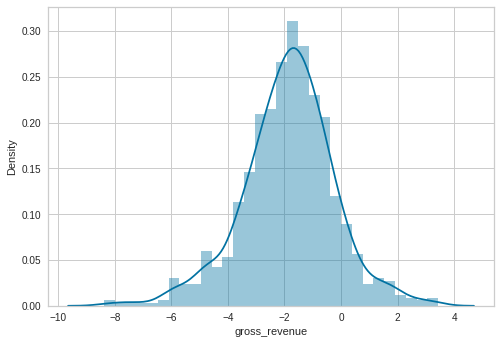

In [ ]:
sns.distplot(np.log(df5['gross_revenue']))

# 6.0 FEATURE SELECTION

In [ ]:
df6= df5.copy()

#7.0 Hyperparameter Fine-Tuning

In [ ]:
X= df6.drop(columns=['customer_id'])

In [ ]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.378073,2.791512,3.893141,-0.033934
1,0.135815,-0.361004,0.621632,-0.033422
2,0.525560,-0.899726,1.406794,-0.026617
3,-0.120552,0.028072,0.098191,-0.023239
4,-0.128660,2.402435,-0.163530,0.152448


In [ ]:
clusters= [2,3,4,5,6,7]

In [ ]:
#wss=[]
#for k in clusters:
  ##model definition
  #kmeans= c.KMeans(init='random',n_clusters=k,n_init=10,max_iter=300,random_state=42)

  ##model training
  #kmeans.fit(X)

  ##validation
  #wss.append(kmeans.inertia_)

##plot wss - elbow method
#plt.plot(clusters,wss,linestyle='--',marker= 'o',color= 'b')
#plt.xlabel('K');
#plt.ylabel('Within-Cluster Sum of Square'); 
#plt.title('WSS vs K');

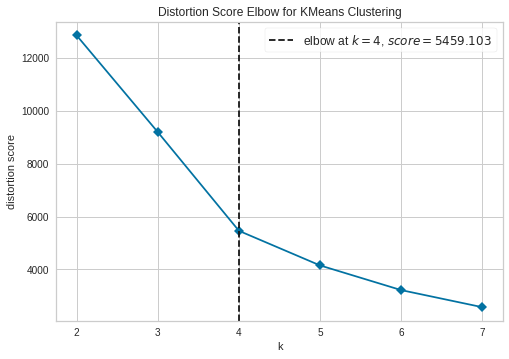

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

kmeans= KElbowVisualizer(c.KMeans(), k=clusters,timings=False)
kmeans.fit(X)
kmeans.show()

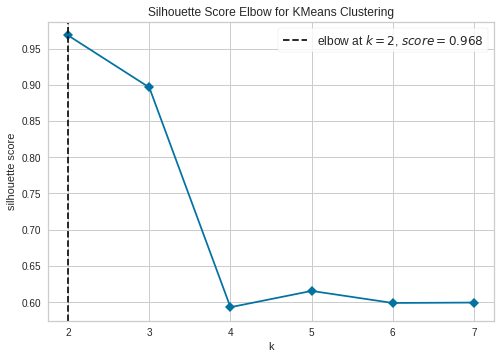

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
kmeans= KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show()

## 7.1 Silhouette Analysis

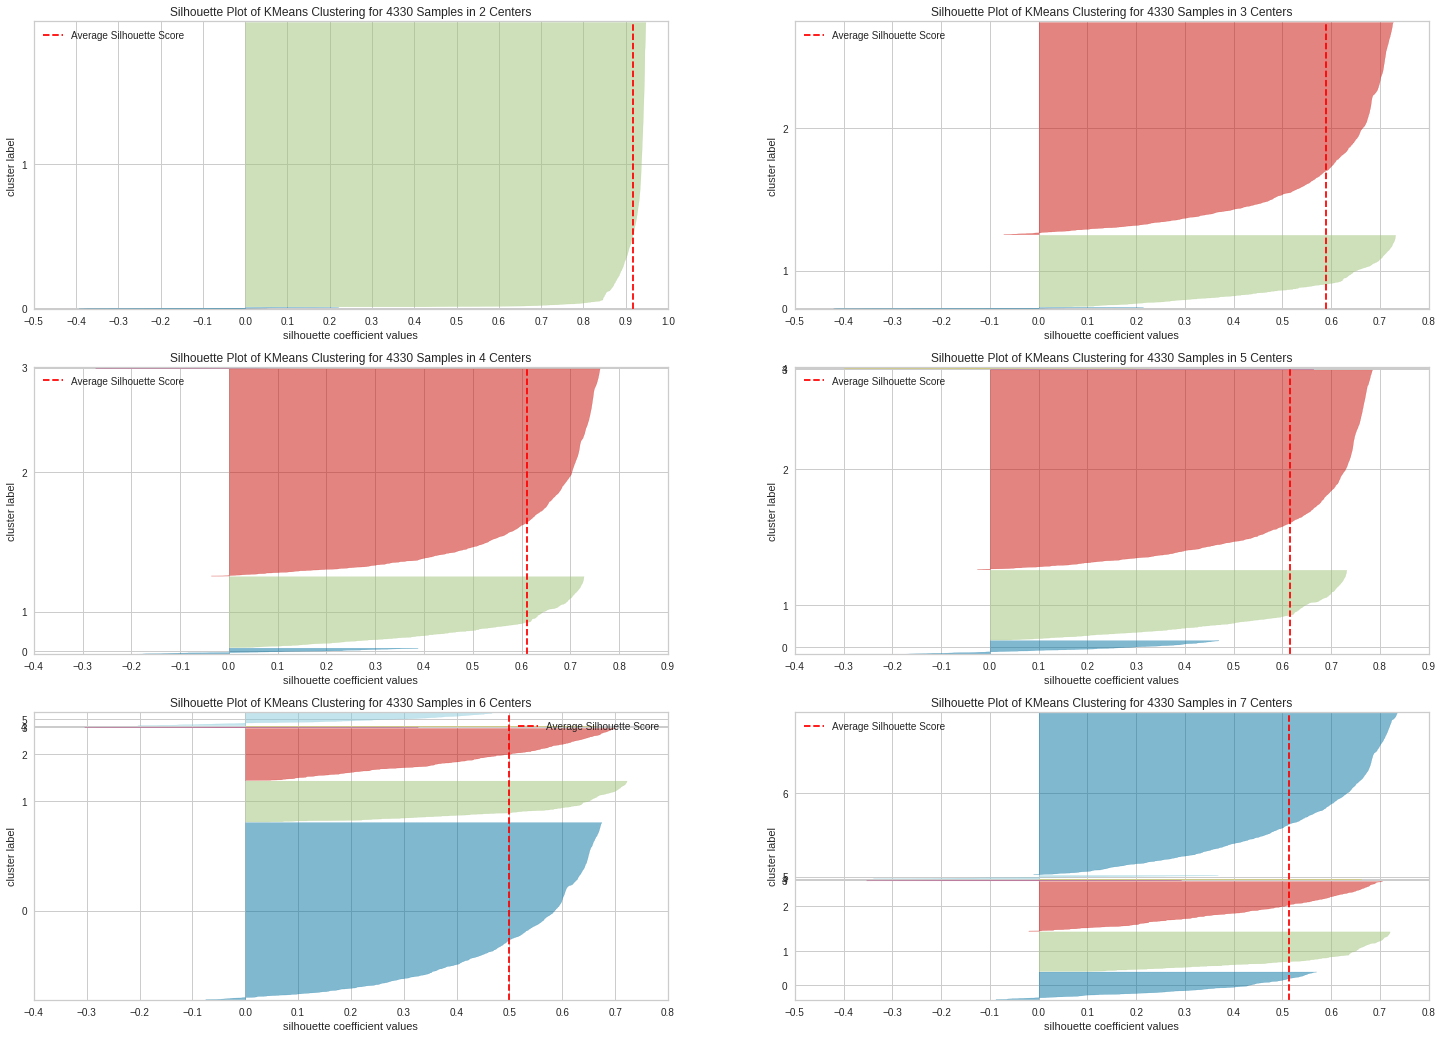

In [ ]:
fig,ax= plt.subplots(3,2,figsize=(25,18))
for k in clusters: 
  km= c.KMeans(n_clusters= k, init='random',n_init=10, max_iter=100, random_state=42)
  q,mod= divmod(k,2)
  visualizer= SilhouetteVisualizer(km, colors='yellowbrick',ax= ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

# 8.0 MODEL TRAINING

## 8.1 K-MEANS

In [ ]:
#model definition
k=3
kmeans= c.KMeans(init='random', n_clusters= k, n_init= 10, max_iter= 300)
#model training
kmeans.fit(X)

#clustering
labels= kmeans.labels_

## 8.2 Cluster Validation

In [ ]:
from sklearn import metrics as m

In [ ]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))
 
#SS
print('SS value: {}'.format(m.silhouette_score(X,labels,metric='euclidean')))

WSS value: 9408.255050647289
SS value: 0.5893633811956627


# 9.0 Cluster Analysis

In [ ]:
df9 = df6.copy()
df9['cluster']= labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378073,2.791512,3.893141,-0.033934,2
1,13047,0.135815,-0.361004,0.621632,-0.033422,1
2,12583,0.525560,-0.899726,1.406794,-0.026617,1
3,13748,-0.120552,0.028072,0.098191,-0.023239,1
4,15100,-0.128660,2.402435,-0.163530,0.152448,2


## 9.1 Visualization Inspection

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


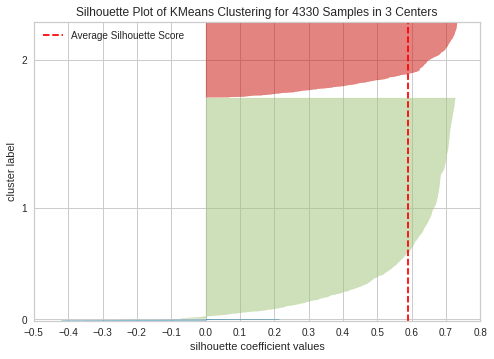

In [ ]:
visualizer= SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2dplot

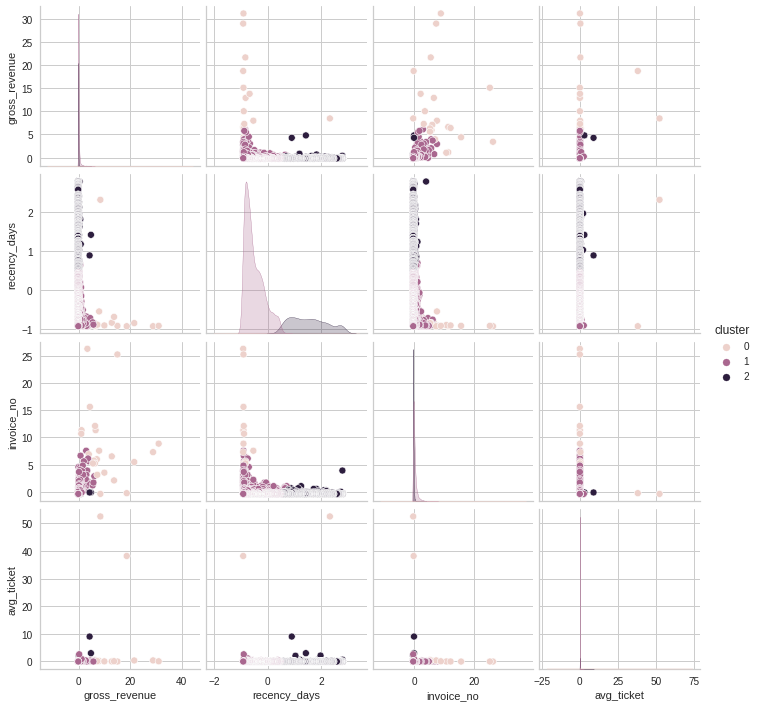

In [ ]:
df_viz= df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz,hue='cluster')

## 9.3 UMAP

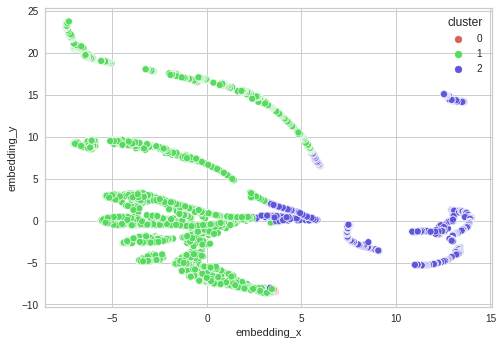

In [ ]:
reducer= umap.UMAP(n_neighbors=35,random_state=42)
embedding= reducer.fit_transform(X)

#embedding
df_viz['embedding_x']= embedding[:,0]
df_viz['embedding_y']= embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls',n_colors=len(df_viz['cluster'].unique())),
                data= df_viz)